Shape initiale : (8807, 12)
Distribution of selected genre :
main_genre
Dramas                          1600
Comedies                        1210
Action & Adventure               859
Documentaries                    829
International TV Shows           774
Children & Family Movies         605
Crime TV Shows                   399
Kids' TV                         388
Stand-Up Comedy                  334
Horror Movies                    275
British TV Shows                 253
Docuseries                       221
Anime Series                     176
International Movies             128
Reality TV                       120
TV Comedies                      120
Classic Movies                    80
TV Dramas                         67
Thrillers                         65
Movies                            57
TV Action & Adventure             40
Stand-Up Comedy & Talk Shows      34
Romantic TV Shows                 32
Classic & Cult TV                 22
Anime Features                    21
Ind

/tmp/ipykernel_36333/2260379169.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts[valid_genres].values, y=genre_counts[valid_genres].index, palette="viridis")


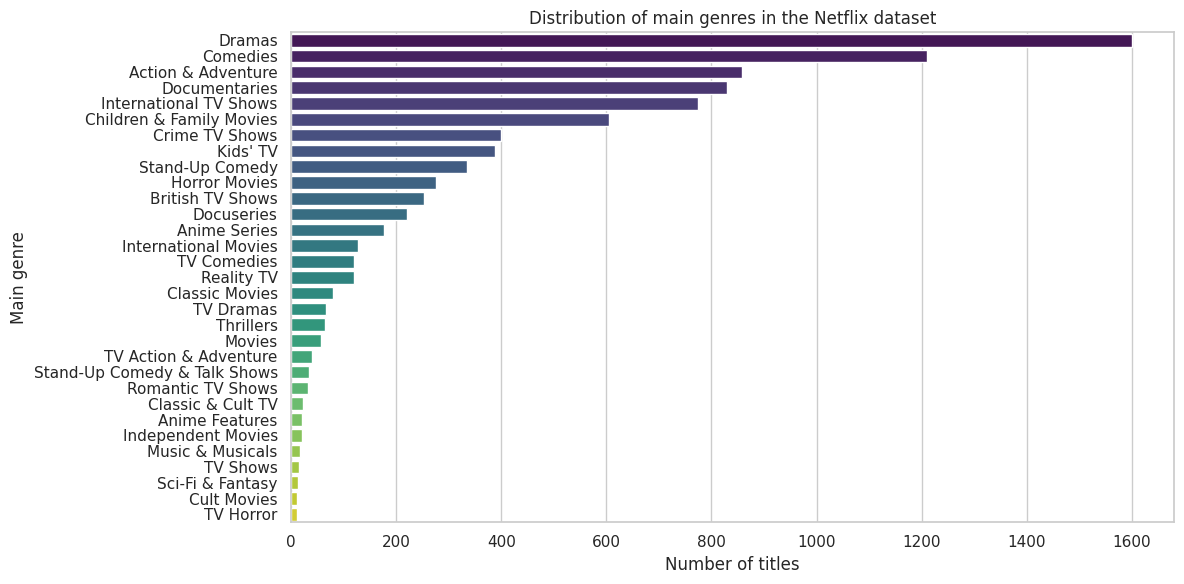

Preprocessing complete, matrices and encoders saved.
Data divided into train/test and saved.


/tmp/ipykernel_36333/2260379169.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 0. 0. ... 1. 1. 1.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_features.loc[:, col] = pd.to_numeric(df_features[col], errors='coerce').fillna(0).astype(np.float32)
/tmp/ipykernel_36333/2260379169.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_features.loc[:, col] = pd.to_numeric(df_features[col], errors='coerce').fillna(0).astype(np.float32)


In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np
import os
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

# 2. Load the personalized stopwords
with open('../data/stopwords_en.txt', 'r') as f:
    stop_words = set(f.read().splitlines())

# 3. Load the original database
df = pd.read_csv('../data/netflix_titles.csv')
print("Shape initiale :", df.shape)

# 4. Clean the database
df.drop_duplicates(inplace=True)
df = df.dropna(subset=['description', 'listed_in'])

# 5. Text pre-processing
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['description'] = df['description'].apply(clean_text)

# 6. Extract the main genre for simplification of the classification
df['main_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip())

# Delete the rare genre (less than 5 occurrences)
genre_counts = df['main_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 5].index
df = df[df['main_genre'].isin(valid_genres)]

# Details of the genre distribution
print("Distribution of selected genre :")
print(df['main_genre'].value_counts())

# Visualisation of the genre distribution
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts[valid_genres].values, y=genre_counts[valid_genres].index, palette="viridis")
plt.title('Distribution of main genres in the Netflix dataset')
plt.xlabel('Number of titles')
plt.ylabel('Main genre')
plt.tight_layout()
plt.show()

# 7. Target encoding (main_genre)
le = LabelEncoder()
y = le.fit_transform(df['main_genre'])

# 8. TF-IDF on description column
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df['description'])

# 9. Encoding of the others variables (ex: type)
df = pd.get_dummies(df, columns=['type'])

# 10. Preparation of encoded numerical and categorical features
cols_to_keep = ['release_year'] + [col for col in df.columns if col.startswith('type_')]
df_features = df[cols_to_keep]

# Conversion to float32 with .loc to avoid SettingWithCopyWarning
for col in df_features.columns:
    df_features.loc[:, col] = pd.to_numeric(df_features[col], errors='coerce').fillna(0).astype(np.float32)

X_other = csr_matrix(df_features.values)

# 11. Combining text and non-text features
X_final = hstack([X_text, X_other])

# 12. Train/test split (stratified by y)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# 13. Saving matrices and objects
os.makedirs('../data', exist_ok=True)
os.makedirs('../models', exist_ok=True)

joblib.dump(X_train, '../data/X_train_sparse.pkl')
joblib.dump(X_test, '../data/X_test_sparse.pkl')
joblib.dump(y_train, '../data/y_train_labels.pkl')
joblib.dump(y_test, '../data/y_test_labels.pkl')

joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
joblib.dump(le, '../models/label_encoder.pkl')

print("Preprocessing complete, matrices and encoders saved.")
print("Data divided into train/test and saved.")